First Variation 


Installation and imports


In [1]:
!pip install librosa
!pip install eli5
!pip install catboost
!pip install tensorflow

     |████████████████████████████████| 216 kB 6.5 MB/s 
     |████████████████████████████████| 133 kB 42.4 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=91893e592b5fd832a285c5ac46c61398df1fa9475e93942fdefce5b38f5d7226
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 76.6 MB 64 kB/s 
     |██████████████████████████

In [2]:
import os
import time

import librosa
from librosa.core.audio import zero_crossings
import librosa.display

import numpy as np

import json

import IPython.display as ipd

%matplotlib inline
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics.pairwise import cosine_similarity

from PIL import Image

import pathlib

import csv

from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
import tensorflow.keras as keras
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

import catboost as cb

import eli5
from eli5.sklearn import PermutationImportance

import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

End of Installation

In [ ]:
audio_file="/content/drive/MyDrive/Colab Notebooks/ML/Course Work/Genres/lo-fi/al-90-dx2ov-odna.mp3"
x, sr = librosa.load(audio_file)

print (type(x), type(sr))

print(x.shape, sr)

#This returns an audio time series as a numpy array with a default sampling rate(sr) of 22KHZ mono.

<class 'numpy.ndarray'> <class 'int'>
(7688606,) 22050


In [ ]:
ipd.Audio(audio_file)

We can plot the audio array using librosa.display.waveplot:

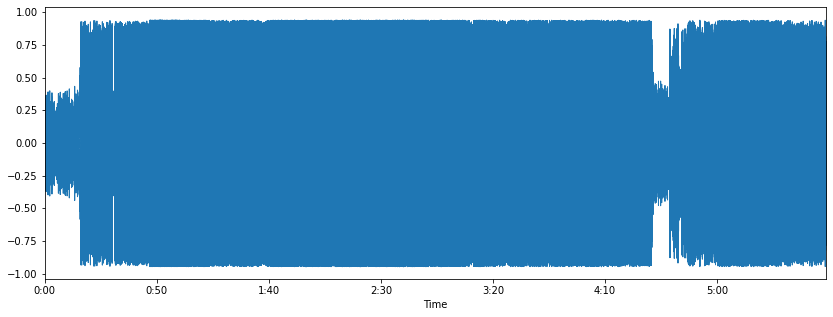

In [ ]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(x, sr=sr)



Zero Crossing Rate

The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. This feature has been used heavily in both speech recognition and music information retrieval. It usually has higher values for highly percussive sounds like those in metal and rock.
Let us calculate the zero crossing rate for our example audio clip.

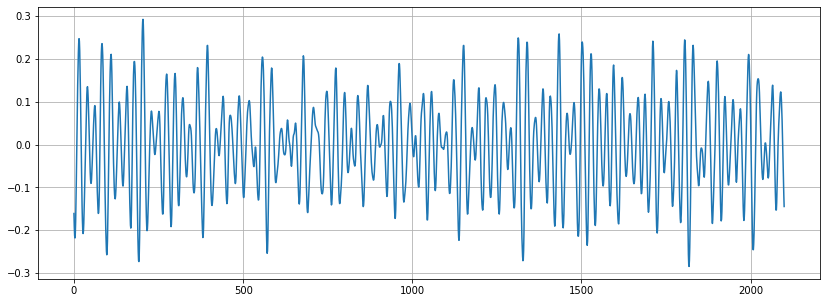

In [ ]:
n0 = 7000
n1 = 9100 

plt.figure(figsize=(14,5))
plt.plot(x[n0:n1])
plt.grid()

Let's count number of zero crossings

In [ ]:
crossings_0 = zero_crossings(x[n0:n1], pad=False)
print(sum(crossings_0))

172


A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. Spectrograms are sometimes called sonographs, voiceprints, or voicegrams. When the data is represented in a 3D plot, they may be called waterfalls. In 2-dimensional arrays, the first axis is frequency while the second axis is time.
We can display a spectrogram using. librosa.display.specshow.

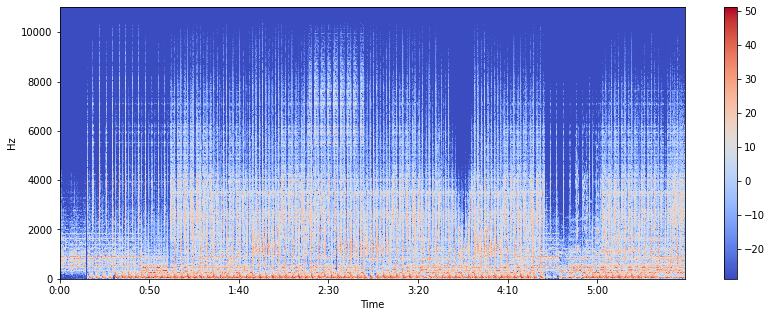

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))

plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()


The vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip. Since we see that all action is taking place at the bottom of the spectrum, we can convert the frequency axis to a logarithmic one.

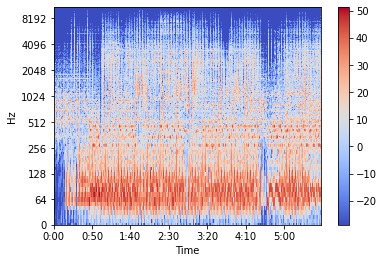

In [ ]:
librosa.display.specshow(Xdb,sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

Spectral Centroid

It indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound. Consider two songs, one from a blues genre and the other belonging to metal. Now as compared to the blues genre song which is the same throughout its length, the metal song has more frequencies towards the end. So spectral centroid for blues song will lie somewhere near the middle of its spectrum while that for a metal song would be towards its end.
librosa.feature.spectral_centroid computes the spectral centroid for each frame in a signal:

(15017,)
CPU times: user 472 ms, sys: 10.9 ms, total: 483 ms
Wall time: 484 ms


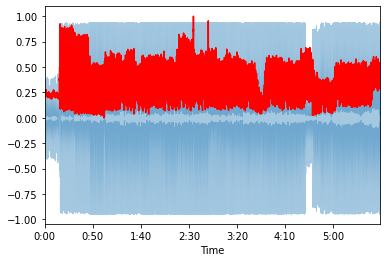

In [ ]:
%%time
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
print(spectral_centroids.shape)

#Computing the time variable for Visualisation
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

#Normalising the spectral centroid for Visualisation
def normalise(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalise(spectral_centroids), color='r')


There is a rise in the spectral centroid towards the end.

Spectral Rolloff

It is a measure of the shape of the signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.
librosa.feature.spectral_rolloff computes the rolloff frequency for each frame in a signal:

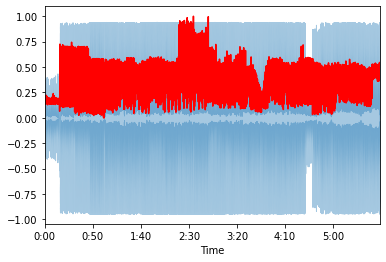

In [ ]:
spectral_rolloff= librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalise(spectral_rolloff), color='r')


Mel-Frequency Cepstral Coefficients

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.
Let’ work with a simple loop wave this time.

librosa.feature.mfcc computes MFCCs across an audio signal:

(20, 15017)


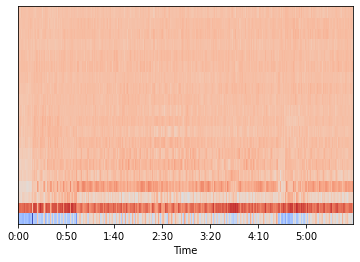

In [ ]:
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

#Display mfcc
librosa.display.specshow(mfccs,sr=sr, x_axis='time')

[ 1.2193213e-08  0.0000000e+00 -8.1288078e-09  4.0644039e-09
  0.0000000e+00 -1.2193213e-08  0.0000000e+00  0.0000000e+00
  4.0644039e-09  0.0000000e+00 -2.0322020e-09  1.2193213e-08
  0.0000000e+00  8.1288078e-09 -7.1127073e-09 -3.0483032e-09
 -8.1288078e-09 -8.1288078e-09  0.0000000e+00  4.0644039e-09]
[0.99999994 0.99999994 1.         1.         0.9999999  1.
 1.         1.         1.         0.9999999  1.         1.
 0.99999994 1.         1.         1.         1.         0.9999999
 1.         0.99999994]
CPU times: user 49.7 ms, sys: 986 µs, total: 50.7 ms
Wall time: 51.7 ms


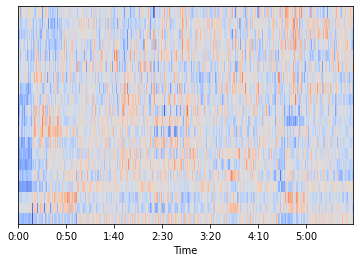

In [ ]:
%%time
# Here mfcc computed 20 MFCC s over 97 frames.
# We can also perform feature scaling such that each coefficient dimension has zero mean and unit variance:

mfccs=sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))
print(mfccs.var(axis=1))

librosa.display.specshow(mfccs, sr=sr, x_axis='time')

Chroma Frequencies

Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chroma) of the musical octave.
librosa.feature.chroma_stft is used for computation

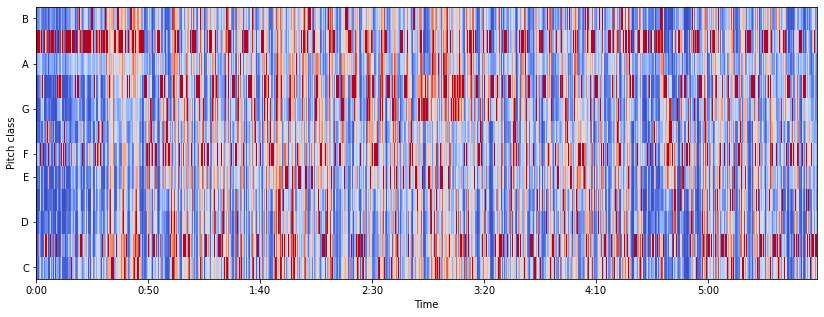

In [ ]:
hop_length=1024
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(14,5))
librosa.display.specshow(chromagram, x_axis="time", y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

Creating an audio signal

Let us now create an audio signal at 220Hz. An audio signal is a numpy array, so we shall create one and pass it into the audio function.

In [ ]:
sr = 22050 #sample rate
T = 5.0 #seconds
squeek_meter=5 #(you can change this variable to a higher value to make it sound more "high")
t= np.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*np.sin(squeek_meter*np.pi*220*t)# pure sinusoid wave at 220HZ

#Playing the audio
ipd.Audio(x,rate=sr)

#To save audio
#librosa.output.write_wave('Some_song_name.wav', x, sr)

Попробуем воспользоваться датасетом GTZAN для того, чтобы обучить модель


In [ ]:
general_path = '/content/drive/MyDrive/Colab Notebooks/ML/Course Work/Data'
print(list(os.listdir(f'{general_path}/genres_original/')))

['jazz', 'pop', 'country', 'metal', 'classical', 'hiphop', 'reggae', 'blues', 'rock', 'disco']


In [ ]:
y, sr = librosa.load(f'{general_path}/genres_original/reggae/reggae.00036.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [ ]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] 

Audio File shape: (661794,)


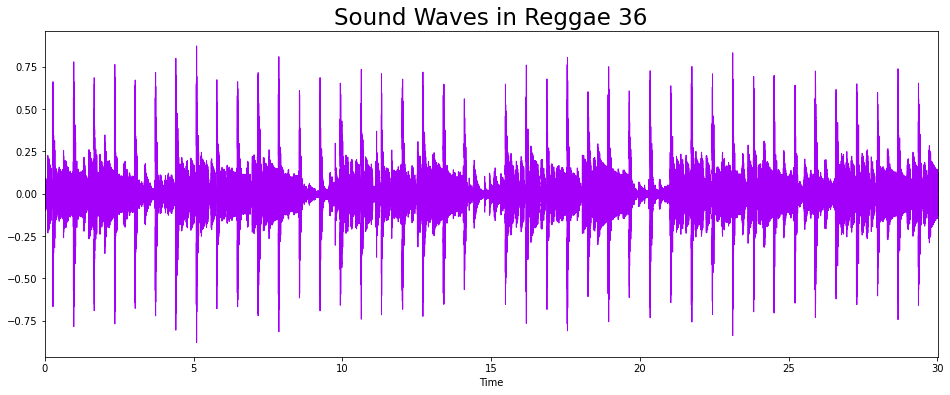

In [ ]:
plt.figure(figsize = (16, 6))
librosa.display.waveplot(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Reggae 36", fontsize = 23);

In [ ]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

Shape of D object: (1025, 1293)


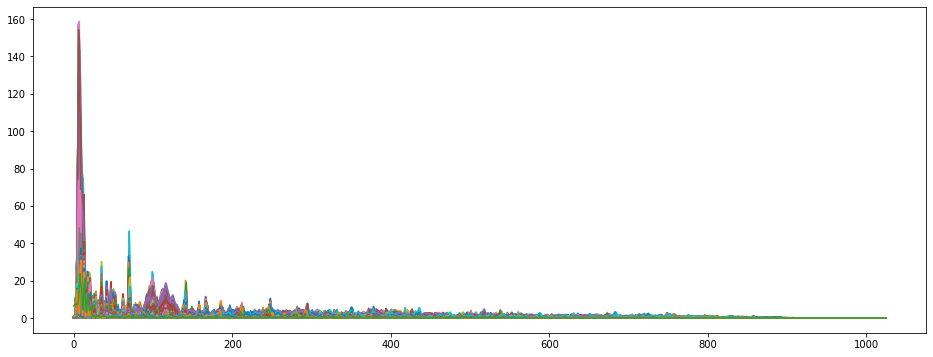

In [ ]:
plt.figure(figsize = (16, 6))
plt.plot(D);

Harmonics and Perceptrual and tempo

Harmonics are characteristichs that human years can't distinguish (represents the sound color)
Perceptrual understanding shock wave represents the sound rhythm and emotion

Dynamic programming beat tracker.

86.1328125

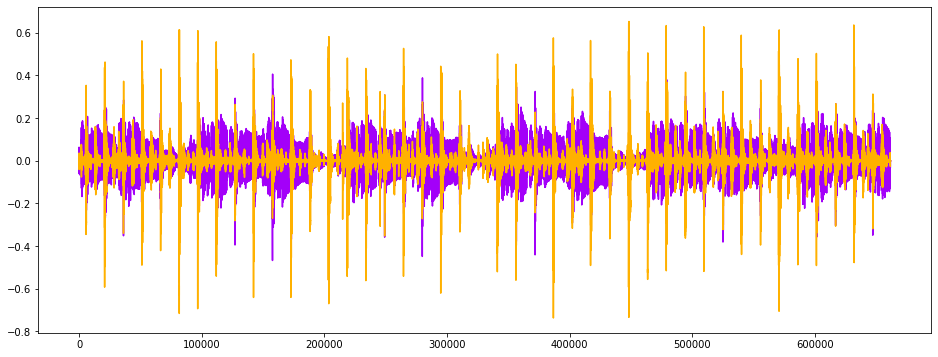

In [ ]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

tempo, _ = librosa.beat.beat_track(y, sr = sr)
tempo

EDA

EDA is going to be performed on the features_30_sec.csv. This file contains the mean and variance for each audio file fo the features analysed above.

So, the table has a final of 1000 rows (10 genrex x 100 audio files) and 60 features (dimensionalities).

In [ ]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


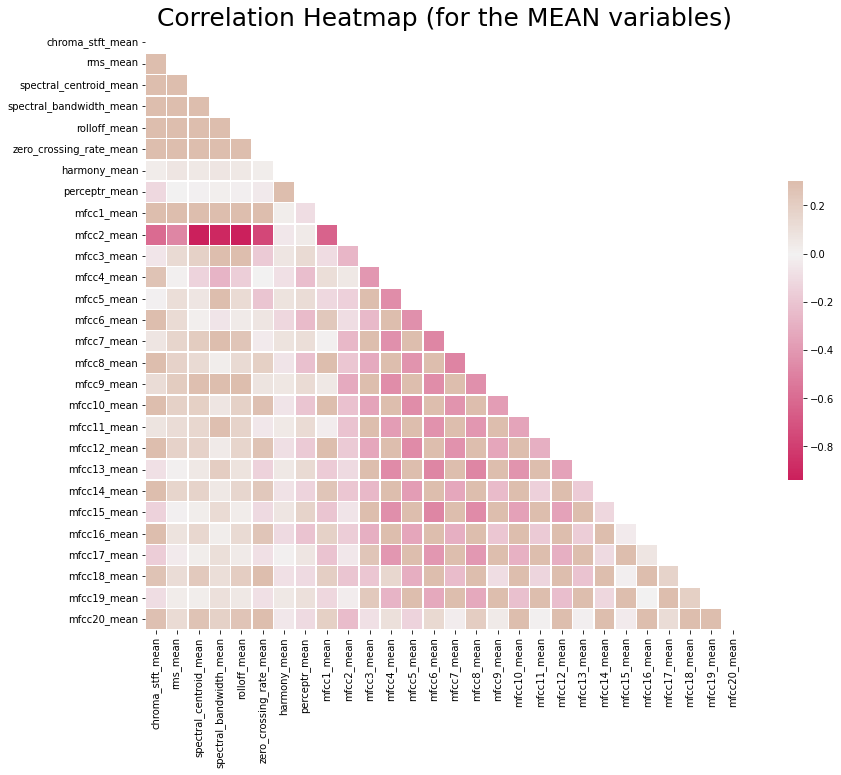

In [ ]:
#Correlation Heatmap for feature means

# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

Box Plot for Genres Distributions

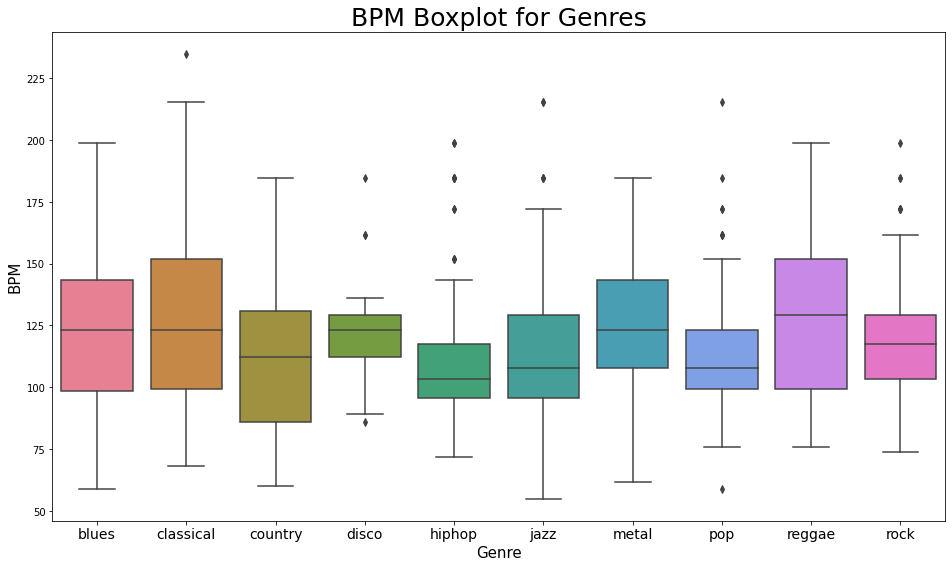

In [ ]:
x = data[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM Boxplot.jpg")

Principal Component Analysis - to visualize possible groups of genres:

Normalization

PCA - метод главных компонент

The Scatter Plot

[0.2439355  0.21781804]


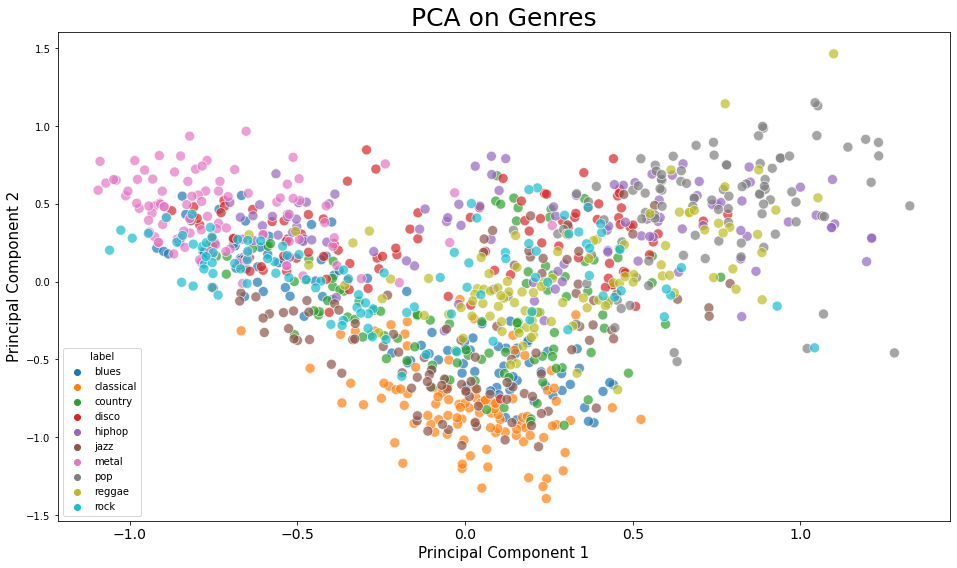

In [ ]:
data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

print(pca.explained_variance_ratio_)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

Теперь мы будем использовать машинное обучение для всего этого дела

In [ ]:
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


Features and Target variable

creates the target and feature variables
normalizes the data

In [ ]:
y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale. 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Creating a Predefined function to assess the accuracy of a model

input is the model

fits the model on the training dataset

predicts on the testing features

compares the predictions with the actuals

In [ ]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [ ]:
%%time
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

Accuracy Naive Bayes : 0.51952 

CPU times: user 26.8 ms, sys: 64 µs, total: 26.9 ms
Wall time: 26.2 ms


In [ ]:
%%time
# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

Accuracy Stochastic Gradient Descent : 0.65532 

CPU times: user 316 ms, sys: 6.94 ms, total: 323 ms
Wall time: 316 ms


In [ ]:
%%time
# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

Accuracy KNN : 0.80581 

CPU times: user 603 ms, sys: 124 ms, total: 727 ms
Wall time: 528 ms


In [ ]:
%%time
# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

Accuracy Decission trees : 0.64064 

CPU times: user 637 ms, sys: 1.86 ms, total: 639 ms
Wall time: 643 ms


In [ ]:
%%time
# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

Accuracy Random Forest : 0.81415 

CPU times: user 35.7 s, sys: 58.5 ms, total: 35.7 s
Wall time: 37 s


In [ ]:
%%time
# catboost
cbc = cb.CatBoostClassifier(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
model_assess(cbc,"Cat Boost Classifier")

Accuracy Cat Boost Classifier : 0.91124 

CPU times: user 3min 8s, sys: 947 ms, total: 3min 9s
Wall time: 1min 47s


In [ ]:
%%time
# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

Accuracy Support Vector Machine : 0.75409 

CPU times: user 3.46 s, sys: 3.92 ms, total: 3.47 s
Wall time: 3.46 s


In [ ]:
%%time
# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

Accuracy Logistic Regression : 0.6977 

CPU times: user 1.14 s, sys: 629 ms, total: 1.77 s
Wall time: 933 ms


In [ ]:
%%time
# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

Accuracy Neural Nets : 0.67167 

CPU times: user 4min 56s, sys: 1min 20s, total: 6min 17s
Wall time: 3min 32s


In [ ]:
%%time
# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

Accuracy Cross Gradient Booster : 0.87988 

CPU times: user 3min 15s, sys: 332 ms, total: 3min 15s
Wall time: 3min 15s


In [ ]:
%%time
# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Cross Gradient Booster (Random Forest) : 0.58859 

CPU times: user 14.5 s, sys: 30.8 ms, total: 14.6 s
Wall time: 14.5 s


In [ ]:
model = XGBClassifier(n_estimators=1000)
model.fit(X_train,y_train,eval_metric='merror')

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
target_names = sorted(set(y))

print(f'Training accuracy: {accuracy_score(y_train,y_pred_train)}')
print(f'Training:\n {classification_report(y_train, y_pred_train, labels=target_names)}')
print(f'Testing accuracy: {accuracy_score(y_test,y_pred_test)}')
print(f'Testing:\n {classification_report(y_test, y_pred_test, labels=target_names)}')

XGBoost is the winner - 90% accuracy

create the final model

compute confusion matrix

Compute Feature Importance

Accuracy : 0.87988 

CPU times: user 3min 15s, sys: 279 ms, total: 3min 16s
Wall time: 3min 15s


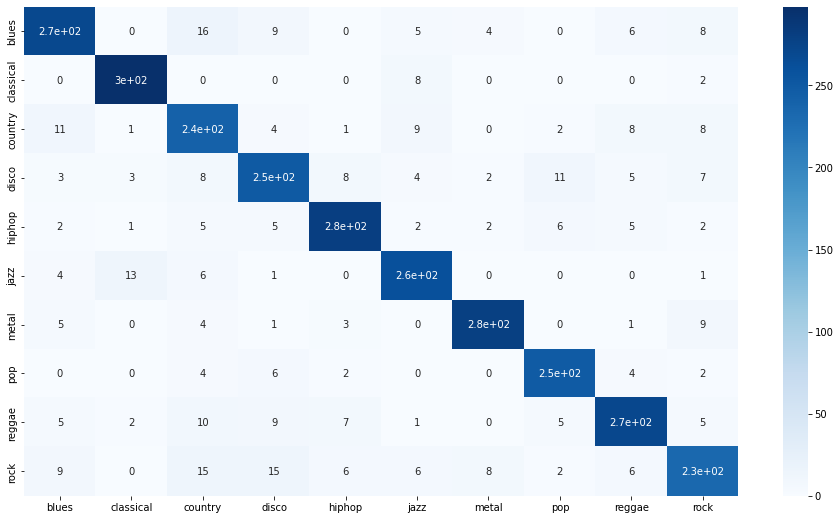

In [ ]:
# Final model
%%time
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig("conf matrix")

In [ ]:
%%time
perm = PermutationImportance(estimator=xgb, random_state=1)
perm.fit(X_test, y_test)

eli5.show_weights(estimator=perm, feature_names = X_test.columns.tolist())

CPU times: user 7min 11s, sys: 409 ms, total: 7min 11s
Wall time: 7min 18s


Recommender Systems

"Recomender" Systems enable us for any given vector to find the best similarity, ranked in descending order, from the bast match to the least best match.

For Audio files, this will be done through cosine_similarity library.

In [ ]:
# Read data
data = pd.read_csv(f'{general_path}/features_30_sec.csv', index_col='filename')

# Extract labels
labels = data[['label']]

# Drop labels from original dataframe
data = data.drop(columns=['length','label'])
data.head()

# Scale the data
data_scaled=preprocessing.scale(data)
print('Scaled data type:', type(data_scaled))

Scaled data type: <class 'numpy.ndarray'>


Cosine similarity

Calculates the pairwise cosine similarity for each combination of songs in the data. This results in a 1000 x 1000 matrix (with redundancy in the information as item A similarity to item B == item B similarity to item A).

In [ ]:
# Cosine similarity
%%time
similarity = cosine_similarity(data_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()

Similarity shape: (1000, 1000)
CPU times: user 9.17 ms, sys: 8.01 ms, total: 17.2 ms
Wall time: 12.3 ms


In [ ]:
def find_similar_songs(name):
    # Find songs most similar to another song
    series = sim_df_names[name].sort_values(ascending = False)
    
    # Remove cosine similarity == 1 (songs will always have the best match with themselves)
    series = series.drop(name)
    
    # Display the 5 top matches 
    print("\n*******\nSimilar songs to ", name)
    print(series.head(5))

Putting the Similarity Function into Action:

POP Example

In [ ]:
# pop.00019 - Britney Spears "Hit me baby one more time"
%%time
find_similar_songs('pop.00019.wav') 

ipd.Audio(f'{general_path}/genres_original/pop/pop.00019.wav')


*******
Similar songs to  pop.00019.wav
filename
pop.00023.wav    0.862836
pop.00034.wav    0.860499
pop.00078.wav    0.829135
pop.00088.wav    0.824456
pop.00091.wav    0.802269
Name: pop.00019.wav, dtype: float64
CPU times: user 16 ms, sys: 70.9 ms, total: 87 ms
Wall time: 581 ms


Попробуем воспользоваться другой моделью

In [ ]:
df = pd.read_csv(f'{general_path}/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
X = df.drop(['label','filename'],axis=1)
y = df['label'] 
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 58), (300, 58), (700,), (300,))

Accuracy : 0.83333 



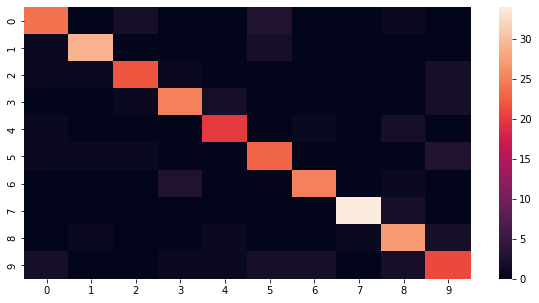

In [ ]:
# Final model
cbc = cb.CatBoostClassifier(verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(X_train, y_train)

preds = cbc.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confus_mat = confusion_matrix(y_test, preds) 
plt.figure(figsize = (10, 5))
sns.heatmap(confus_mat)

Deep learning model time

In [ ]:
X_train.shape[1]

58

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=(58,)))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 58)                0         
                                                                 
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [ ]:
#In order to prevent our model from overfitting we wll use callbacks
early_stopping= EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5) 
check_pointer = ModelCheckpoint(filepath = 'clf-resnet-checkpoint.hdf5',verbose=1,save_best_only=True) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss',mode='min',verbose=1,patience=5,min_delta = 0.0001,factor=0.2) 
callbacks = [check_pointer,early_stopping,reduce_lr]


In [ ]:
# compile the model
adam = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
#Now our model is ready to train

hist = model.fit(X_train, y_train,
                 validation_data = (X_test,y_test),
                 epochs = 100,
                 batch_size = 32, callbacks = [check_pointer,early_stopping])

Epoch 1/100
14/22 [==================>...........] - ETA: 0s - loss: 4.4294 - accuracy: 0.0960 
Epoch 1: val_loss improved from inf to 4.35179, saving model to clf-resnet-checkpoint.hdf5
22/22 [==============================] - 1s 18ms/step - loss: 4.4091 - accuracy: 0.1043 - val_loss: 4.3518 - val_accuracy: 0.1200
Epoch 2/100
21/22 [===========================>..] - ETA: 0s - loss: 4.3160 - accuracy: 0.1205
Epoch 2: val_loss improved from 4.35179 to 4.25526, saving model to clf-resnet-checkpoint.hdf5
22/22 [==============================] - 0s 8ms/step - loss: 4.3151 - accuracy: 0.1171 - val_loss: 4.2553 - val_accuracy: 0.0933
Epoch 3/100
13/22 [================>.............] - ETA: 0s - loss: 4.2391 - accuracy: 0.1274
Epoch 3: val_loss improved from 4.25526 to 4.15947, saving model to clf-resnet-checkpoint.hdf5
22/22 [==============================] - 0s 7ms/step - loss: 4.2222 - accuracy: 0.1200 - val_loss: 4.1595 - val_accuracy: 0.1200
Epoch 4/100
13/22 [================>.........

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

10/10 [==============================] - 0s 2ms/step - loss: 1.6405 - accuracy: 0.5900
Test accuracy: 0.5899999737739563


Plot Accuracy and Loss

<Figure size 1440x1080 with 0 Axes>

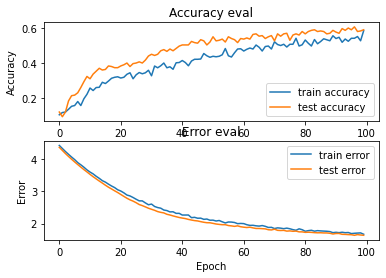

In [ ]:
plt.figure(figsize=(20,15))
fig, axs = plt.subplots(2)

# accuracy 
axs[0].plot(hist.history["accuracy"], label="train accuracy")
axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")
    
# Error 
axs[1].plot(hist.history["loss"], label="train error")
axs[1].plot(hist.history["val_loss"], label="test error")    
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")
    
plt.show()

Создадим собственный датасет из нашей музыки !

In [3]:
%%time
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = ["Deep_house", "Electronic_music","Experimental_Electronic_music", "Rock", "Techno","lo-fi","My_Music"]
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'/content/drive/MyDrive/Colab Notebooks/ML/Course Work/Genres/{g}'):
        songname = f'/content/drive/MyDrive/Colab Notebooks/ML/Course Work/Genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB')
        plt.axis('off')
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

CPU times: user 1min 7s, sys: 8.17 s, total: 1min 15s
Wall time: 4min 1s


<Figure size 576x576 with 0 Axes>

In [4]:
#Создаем Header для файла CSV
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

Извлекаем признаки из спектрограммы: MFCC, спектральный центроид, частоту пересечения нуля, частоты цветности и спад спектра.

In [5]:
%%time
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = ["Deep_house", "Electronic_music","Experimental_Electronic_music", "Rock", "Techno","lo-fi","My_Music"]


for g in genres:
    for filename in os.listdir(f'/content/drive/MyDrive/Colab Notebooks/ML/Course Work/Genres/{g}'):
        songname = f'/content/drive/MyDrive/Colab Notebooks/ML/Course Work/Genres/{g}/{filename}'

        y, sr = librosa.load(songname, mono=True, duration=30)
        rmse = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        filename = filename.replace(' ', '_')
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

CPU times: user 3min 59s, sys: 28.8 s, total: 4min 28s
Wall time: 4min 58s


Вот что мы получаем

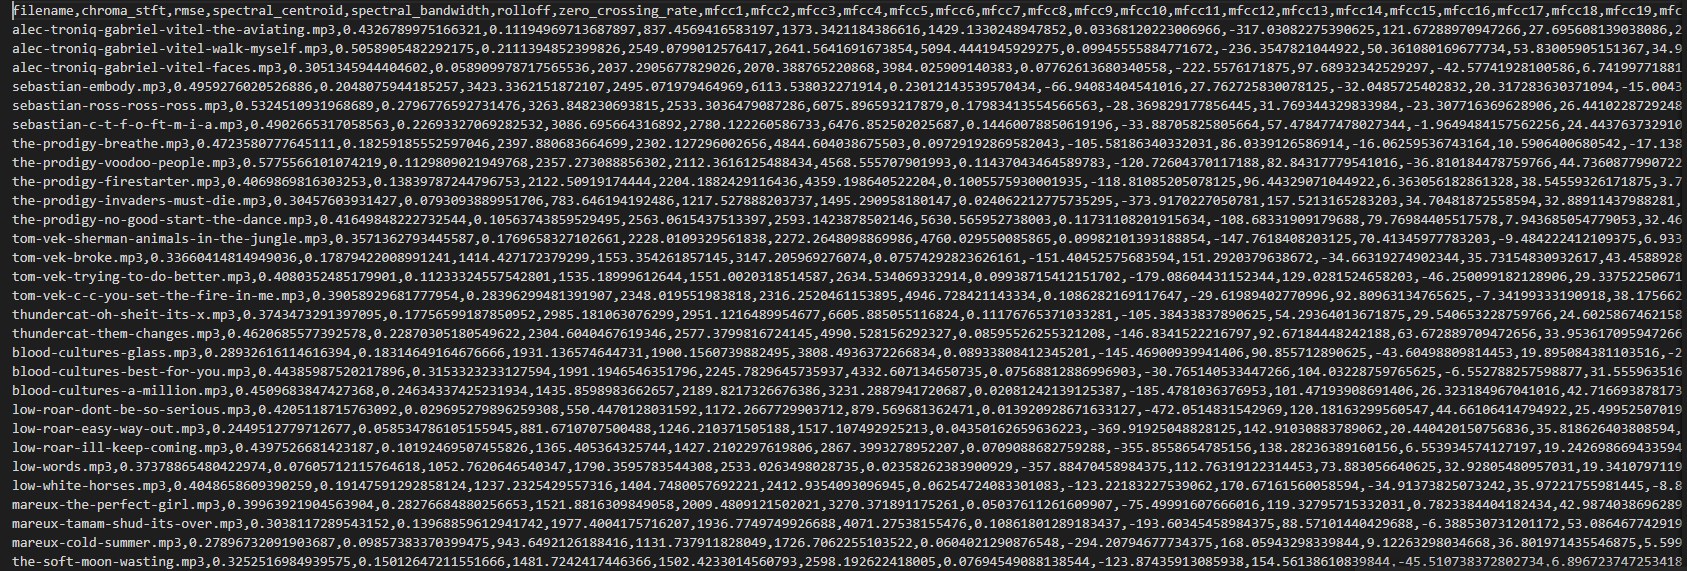

Выполняем предварительную обработку данных, которая включает загрузку данных CSV, создание меток, масштабирование признаков и разбивку данных на наборы для обучения и тестирования.

In [6]:
data = pd.read_csv('dataset.csv')
data.head()
# Удаление ненужных столбцов
data = data.drop(['filename'],axis=1)
# Создание меток
genre_list = data.iloc[:, -1]
encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
# Масштабирование столбцов признаков
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
# Разделение данных на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Создаем модель ANN

In [7]:
model = Sequential()
model.add(keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
#Вставляем в нашу модель данные
%%time
classifier = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

Epoch 1/100
1/1 [==============================] - 1s 976ms/step - loss: 2.4051 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 2.2728 - accuracy: 0.1346
Epoch 3/100
1/1 [==============================] - 0s 12ms/step - loss: 2.1650 - accuracy: 0.2885
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 2.0716 - accuracy: 0.4231
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 1.9895 - accuracy: 0.4327
Epoch 6/100
1/1 [==============================] - 0s 10ms/step - loss: 1.9150 - accuracy: 0.4423
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 1.8447 - accuracy: 0.4615
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 1.7782 - accuracy: 0.4615
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 1.7164 - accuracy: 0.4519
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 1.6602 - accuracy: 0.4519
Epoch 11/100
1/1 

In [9]:
genres = ["Deep_house", "Electronic_music","Experimental_Electronic_music", "Rock", "Techno","lo-fi","My_Music"]
for g in genres:
    pathlib.Path(f'img_data/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'/content/drive/MyDrive/Colab Notebooks/ML/Course Work/Genres/{g}'):
        songname = f'/content/drive/MyDrive/Colab Notebooks/ML/Course Work/Genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        #print(y.shape)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'img_data/{g}/{filename[:-3].replace(".", "")}.png')
        
        plt.clf()

(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)
(110250,)


<Figure size 432x288 with 0 Axes>

In [10]:
!pip install split-folders

In [11]:
import splitfolders
# Для создания наборов для обучения и тестирования устанавливаем кортеж в `ratio`, т.е., `(.8, .2)`.
splitfolders.ratio('./img_data/', output="./data", seed=1337, ratio=(.8, .2)) # значения по умолчанию

Copying files: 131 files [00:00, 3547.50 files/s]


In [12]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255, # изменение масштаба всех значений пикселей с 0 до 255, после этого шага они будут находится в диапазоне (0,1)
        shear_range=0.2, # применение случайных преобразований
        zoom_range=0.2, # увеличение масштаба
        horizontal_flip=True) # горизонтальный поворот
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
training_set = train_datagen.flow_from_directory(
        './data/train',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False)
test_set = test_datagen.flow_from_directory(
        './data/val',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle = False )

Found 101 images belonging to 7 classes.
Found 30 images belonging to 7 classes.


In [21]:
model = Sequential()
input_shape=(64, 64, 3)#1st hidden layer
model.add(Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#2nd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#3rd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))#Flatten
model.add(Flatten())
model.add(Dropout(rate=0.5))#Add fully connected layer.
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))#Output layer
model.add(Dense(7))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 31, 31, 32)        896       
                                                                 
 average_pooling2d_6 (Averag  (None, 15, 15, 32)       0         
 ePooling2D)                                                     
                                                                 
 activation_10 (Activation)  (None, 15, 15, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 average_pooling2d_7 (Averag  (None, 7, 7, 64)         0         
 ePooling2D)                                                     
                                                                 
 activation_11 (Activation)  (None, 7, 7, 64)         

In [22]:
from tensorflow.keras.optimizers import SGD
epochs = 200
batch_size = 8
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=['accuracy'])

In [29]:
model.fit_generator(
        training_set,
        #steps_per_epoch=50,
        epochs=200,
        validation_data=test_set,
        #validation_steps=200
        )

Epoch 1/200
4/4 [==============================] - 1s 350ms/step - loss: 1.7843 - accuracy: 0.2277 - val_loss: 1.8136 - val_accuracy: 0.1667
Epoch 2/200
4/4 [==============================] - 2s 387ms/step - loss: 1.8220 - accuracy: 0.2277 - val_loss: 1.8131 - val_accuracy: 0.1667
Epoch 3/200
4/4 [==============================] - 1s 246ms/step - loss: 1.8498 - accuracy: 0.1782 - val_loss: 1.8116 - val_accuracy: 0.1667
Epoch 4/200
4/4 [==============================] - 1s 245ms/step - loss: 1.7902 - accuracy: 0.2277 - val_loss: 1.8138 - val_accuracy: 0.1667
Epoch 5/200
4/4 [==============================] - 1s 318ms/step - loss: 1.8333 - accuracy: 0.1881 - val_loss: 1.8148 - val_accuracy: 0.1667
Epoch 6/200
4/4 [==============================] - 1s 232ms/step - loss: 1.8287 - accuracy: 0.2673 - val_loss: 1.8156 - val_accuracy: 0.1667
Epoch 7/200
4/4 [==============================] - 1s 232ms/step - loss: 1.8051 - accuracy: 0.2178 - val_loss: 1.8173 - val_accuracy: 0.1667
Epoch 8/200
4

In [52]:
model.evaluate_generator(generator=test_set)

[1.7840908765792847, 0.1666666716337204]

In [53]:
test_set.reset()
pred = model.predict_generator(test_set, verbose=1)

1/1 [==============================] - 0s 227ms/step


In [54]:
predicted_class_indices=np.argmax(pred,axis=1)

labels = (training_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions = predictions[:200]
filenames=test_set.filenames

In [55]:
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("prediction_results.csv",index=False)

In [39]:
print(X_train.shape)

(104, 26)


Accuracy : 0.25926 

CPU times: user 551 ms, sys: 15.1 ms, total: 566 ms
Wall time: 849 ms


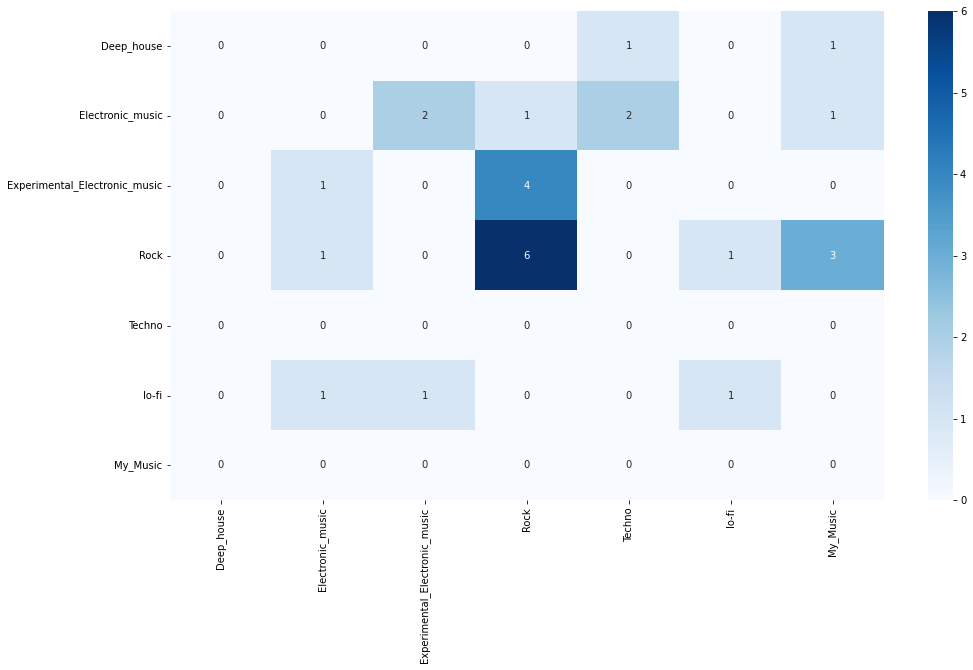

In [37]:
# Final model
%%time
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05)
xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["Deep_house", "Electronic_music","Experimental_Electronic_music", "Rock", "Techno","lo-fi","My_Music"],
           yticklabels=["Deep_house", "Electronic_music","Experimental_Electronic_music", "Rock", "Techno","lo-fi","My_Music"]);
plt.savefig("conf matrix")

Теперь опробуем вставить туда что-нибудь

In [ ]:
# Read data
data = pd.read_csv(f'dataset.csv', index_col='filename')

# Extract labels
labels = data[['label']]

# Drop labels from original dataframe
data = data.drop(columns=['label'])
data.head()

# Scale the data
data_scaled=preprocessing.scale(data)
print('Scaled data type:', type(data_scaled))

Scaled data type: <class 'numpy.ndarray'>


In [ ]:
# Cosine similarity
%%time
similarity = cosine_similarity(data_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()


Similarity shape: (125, 125)
CPU times: user 5.27 ms, sys: 3.88 ms, total: 9.15 ms
Wall time: 11.6 ms


In [ ]:
def find_similar_songs(name):
    # Find songs most similar to another song
    series = sim_df_names[name].sort_values(ascending = False)
    
    # Remove cosine similarity == 1 (songs will always have the best match with themselves)
    series = series.drop(name)
    
    # Display the 5 top matches 
    print("\n*******\nSimilar songs to ", name)
    print(series.head(5))
    print (series)
  

In [ ]:
# pop.00019 - Britney Spears "Hit me baby one more time"
%%time
find_similar_songs('светлана-разина-музыка-нас-связала.mp3') 

#ipd.Audio(f'{general_path}/genres_original/pop/pop.00019.wav')


*******
Similar songs to  светлана-разина-музыка-нас-связала.mp3
filename
sebastian-ross-ross-ross.mp3      0.840428
soulwax-any-minute-now.mp3        0.836096
Eshi.mp3                          0.802508
soulwax-miserable-girl.mp3        0.799059
sebastian-c-t-f-o-ft-m-i-a.mp3    0.782176
Name: светлана-разина-музыка-нас-связала.mp3, dtype: float64
filename
sebastian-ross-ross-ross.mp3                                             0.840428
soulwax-any-minute-now.mp3                                               0.836096
Eshi.mp3                                                                 0.802508
soulwax-miserable-girl.mp3                                               0.799059
sebastian-c-t-f-o-ft-m-i-a.mp3                                           0.782176
                                                                           ...   
erol-alkan-connan-mockasin-forever-dolphin-love-erol-alkan-rework.mp3   -0.607304
Guess_The_Feeling.mp3                                             